# 🏦 Home Credit Default Risk – Kaggle Project

##  Overview
This project uses the **Home Credit Default Risk dataset** from Kaggle.  
The goal is to predict whether a client will **repay (0)** or **default (1)** on a loan.  

We will:
1. Load and explore the data  
2. Preprocess features (IDs, categoricals, missing values)  
3. Train a **baseline Logistic Regression** model  
4. Train an **optimized LightGBM** model (faster and stronger)  
5. Evaluate performance with **AUC**  
6. Generate a **submission file** for Kaggle  


In [94]:
#  Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Set global options
pd.set_option('display.max_columns', 50)


##  Step 2: Load Data
We’ll read `application_train.csv` and `application_test.csv` as starting point.  


In [96]:
# Path to dataset
data_path = "/Users/neerakumar/Downloads/home-credit-default-risk"

# Load training and test data
train = pd.read_csv(f"{data_path}/application_train.csv")
test  = pd.read_csv(f"{data_path}/application_test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Quick preview
train.head()


Train shape: (307511, 122)
Test shape: (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## 🔍 Step 3: Exploratory Data Analysis (EDA)
We’ll look at:
- Target distribution
- Missing values
- Basic statistics


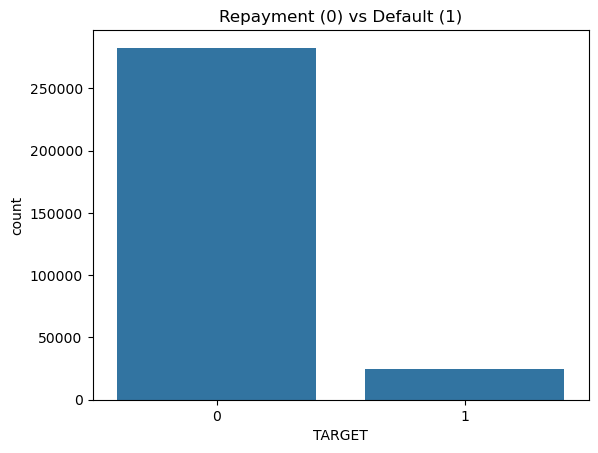

Default Rate: 8.07 %
Top Missing Values:
 COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
dtype: float64


In [98]:
# Target distribution
sns.countplot(x='TARGET', data=train)
plt.title("Repayment (0) vs Default (1)")
plt.show()

# Percentage of defaults
print("Default Rate:", round(train['TARGET'].mean()*100, 2), "%")

# Top missing values
missing = train.isnull().mean().sort_values(ascending=False).head(10)
print("Top Missing Values:\n", missing)


##  Step 4: Preprocessing
- Drop ID column
- One-hot encode categorical variables
- Align train/test columns


In [100]:
# Target variable
y = train['TARGET']

# Save IDs for later (submission)
train_id = train['SK_ID_CURR']
test_id  = test['SK_ID_CURR']

# Drop IDs & target
X = train.drop(columns=['TARGET','SK_ID_CURR'])
test_X = test.drop(columns=['SK_ID_CURR'])

# One-hot encode categorical variables
X = pd.get_dummies(X)
test_X = pd.get_dummies(test_X)

# Align train and test
X, test_X = X.align(test_X, join='left', axis=1, fill_value=0)

print("Train shape after preprocessing:", X.shape)
print("Test shape after preprocessing:", test_X.shape)

# Split train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train shape after preprocessing: (307511, 244)
Test shape after preprocessing: (48744, 244)


In [104]:
# Handle missing values with median imputation
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_valid_imp = imputer.transform(X_valid)

# Logistic Regression
log_reg = LogisticRegression(max_iter=200, solver='lbfgs')
log_reg.fit(X_train_imp, y_train)

# Predict & evaluate
y_pred_log = log_reg.predict_proba(X_valid_imp)[:,1]
print("Baseline Logistic Regression AUC:", roc_auc_score(y_valid, y_pred_log))


Baseline Logistic Regression AUC: 0.6247072653710632


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [109]:
#  Clean feature names (remove special characters)
X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]
X_valid.columns = X_train.columns
test_X.columns  = X_train.columns


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11407
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
LightGBM Validation AUC: 0.7590487405528683


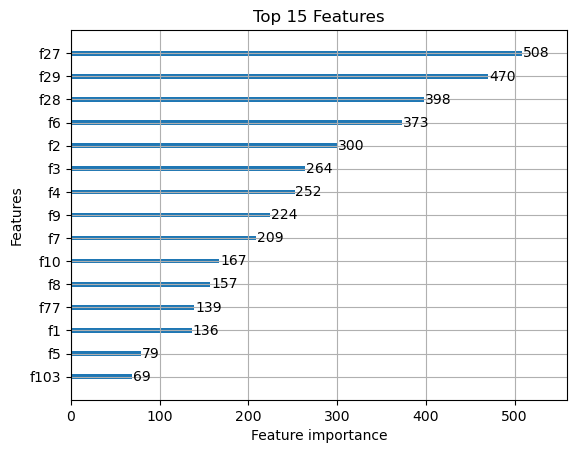

In [112]:
# Clean feature names
X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]
X_valid.columns = X_train.columns
test_X.columns  = X_train.columns

# Convert datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid)

# Parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31
}

# Train LightGBM
model = lgb.train(params, lgb_train, num_boost_round=200, valid_sets=[lgb_valid])

# Predictions
y_pred_lgb = model.predict(X_valid)
print("LightGBM Validation AUC:", roc_auc_score(y_valid, y_pred_lgb))

# Feature importance
lgb.plot_importance(model, max_num_features=15)
plt.title("Top 15 Features")
plt.show()


In [116]:
# Predict on test set
test_preds = model.predict(test_X)

# Make Kaggle submission file
submission = pd.DataFrame({
    'SK_ID_CURR': test_id,   # IDs from original test file
    'TARGET': test_preds
})

submission.to_csv("submission.csv", index=False)
print(" Submission file saved as submission.csv")


 Submission file saved as submission.csv
